## Tentativa de Previsão de Oleo com base em dados Multivariados

#### Carregando libs necessárias

In [39]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error , mean_squared_error



from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

#### Função para a preparação dos dados para o modelo de previsão

In [40]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

#### Carregando a base de dados

In [41]:
###########################################################
file_name = "src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


#### Verificação se todos os dados da base são referentes a um poço produtor

In [42]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()

DATEPRD                       0
WELL_BORE_CODE                0
NPD_WELL_BORE_CODE            0
NPD_WELL_BORE_NAME            0
NPD_FIELD_CODE                0
NPD_FIELD_NAME                0
NPD_FACILITY_CODE             0
NPD_FACILITY_NAME             0
ON_STREAM_HRS                 0
AVG_DOWNHOLE_PRESSURE         3
AVG_DOWNHOLE_TEMPERATURE      3
AVG_DP_TUBING                 3
AVG_ANNULUS_PRESS           728
AVG_CHOKE_SIZE_P              0
AVG_CHOKE_UOM                 0
AVG_WHP_P                     0
AVG_WHT_P                     0
DP_CHOKE_SIZE                 0
BORE_OIL_VOL                  0
BORE_GAS_VOL                  0
BORE_WAT_VOL                  0
BORE_WI_VOL                 744
FLOW_KIND                     0
WELL_TYPE                     0
dtype: int64

#### Remoção de colunas desnecessárias

In [43]:
df_filter=df_filter.drop(columns=['WELL_BORE_CODE','NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
                                  'NPD_FIELD_CODE','NPD_FIELD_NAME',
                                  'NPD_FACILITY_CODE','NPD_FACILITY_NAME',
                                  'AVG_CHOKE_UOM','FLOW_KIND',
                                  'WELL_TYPE','BORE_WI_VOL'])

#### Plot de todos os dados da base de dados

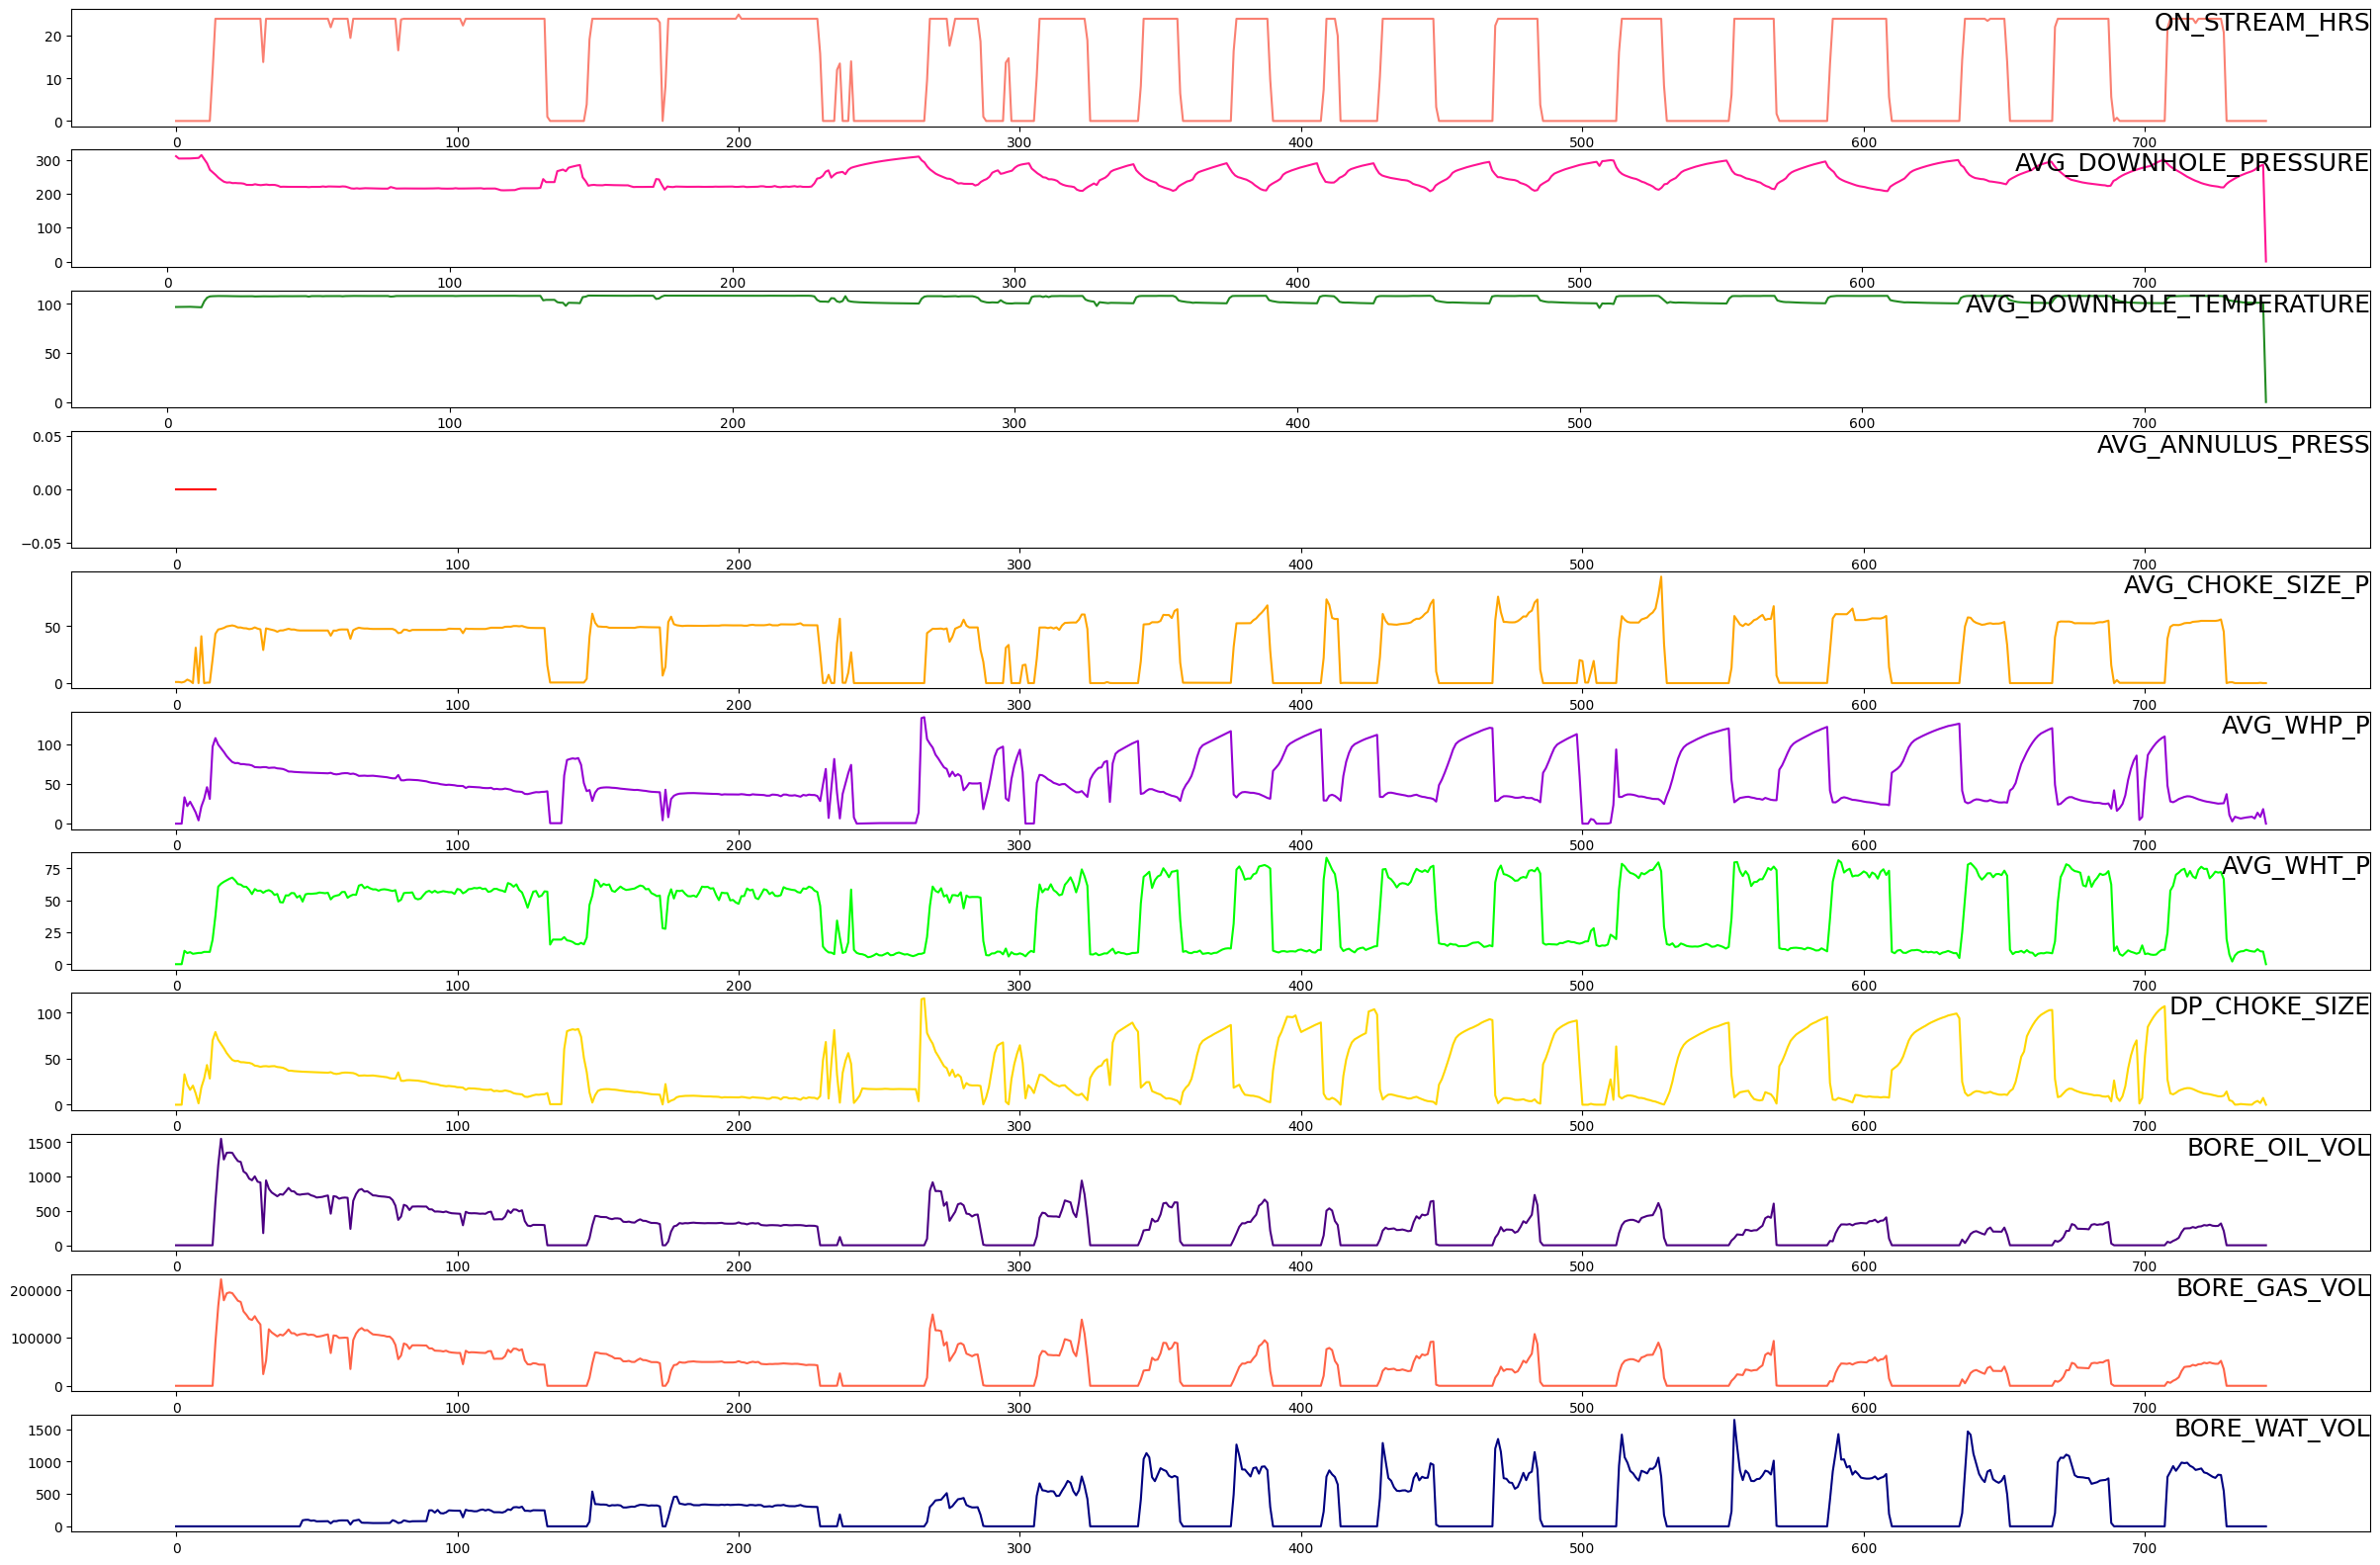

In [44]:
values = df_filter.values

# specify columns to plot
groups = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
colors=['blue','salmon','deeppink',"forestgreen",'red','orange','darkviolet','lime','gold','indigo','tomato','navy']

# plot each column
plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = colors[i])
    plt.title(df_filter.columns[group], y=0.75, loc='right', fontsize = 18)
    i += 1
plt.show()

#### Filtro para selecionar apenas as features desejadas

In [45]:
target = df_filter[['BORE_OIL_VOL','BORE_WAT_VOL','BORE_GAS_VOL','AVG_WHP_P','AVG_WHT_P','ON_STREAM_HRS']]

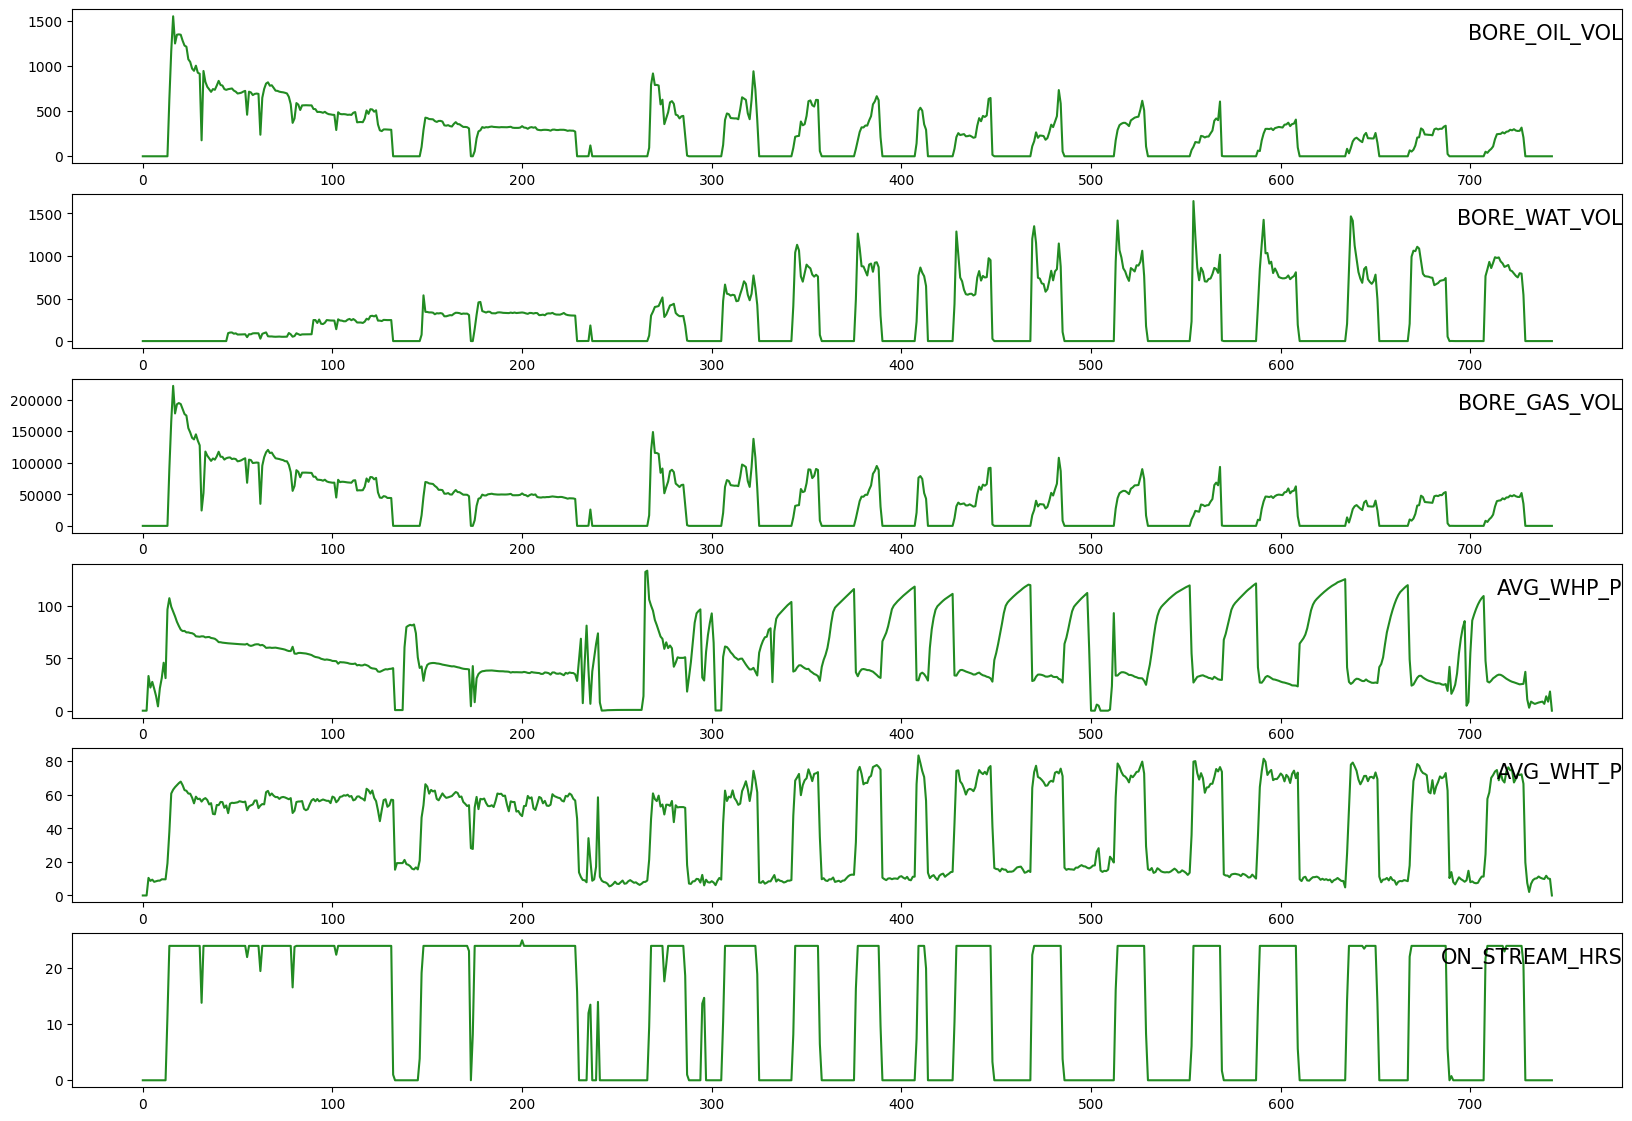

In [46]:
values = target.values

# specify columns to plot
groups = [0, 1, 2, 3, 4,5]
i = 1
# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(target.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

#### Visualização do perfil completo da produção de Oleo

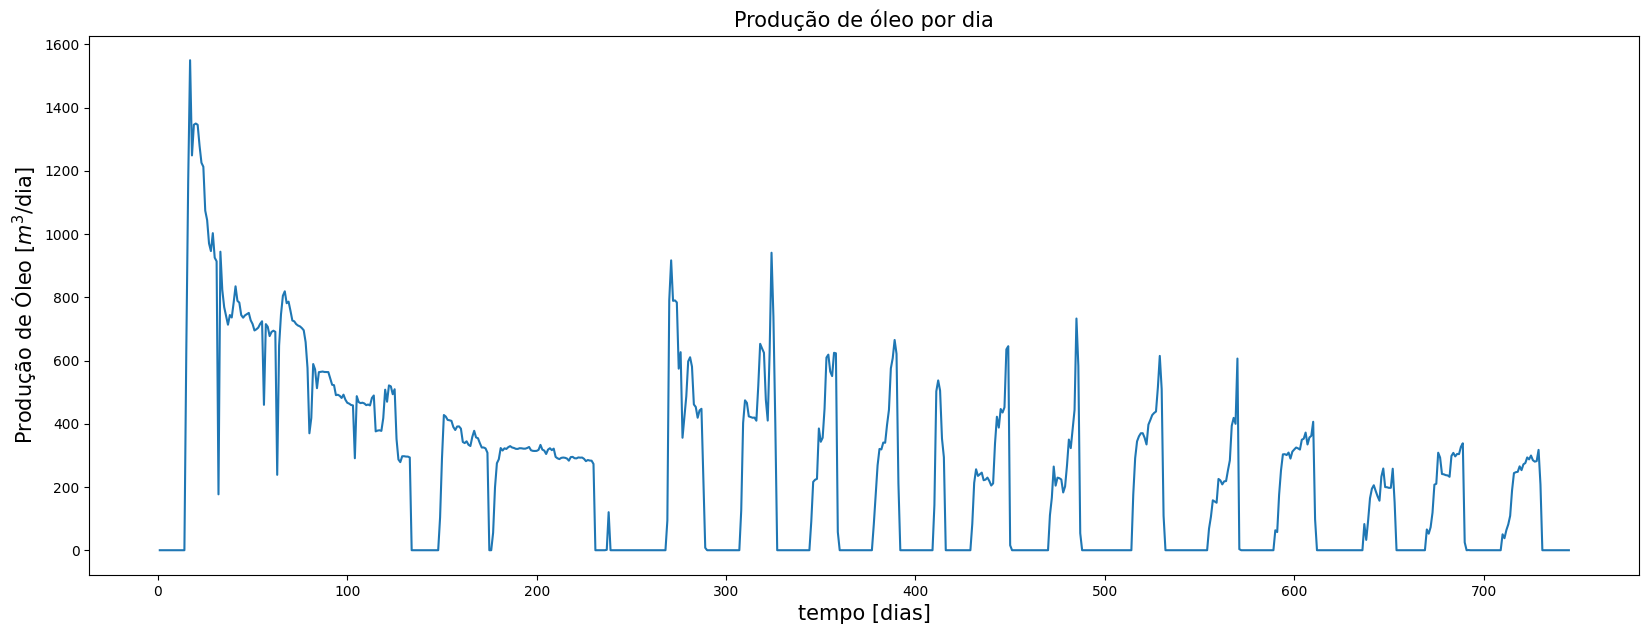

In [47]:
fig = plt.figure(figsize = (20,7))
plt.plot(target.BORE_OIL_VOL)
plt.title("Produção de óleo por dia", fontsize = 15)
plt.xlabel('tempo [dias]', fontsize = 15)
plt.ylabel(r'Produção de Óleo [$m^3$/dia]', fontsize = 15)  # LaTeX formatting for the y-label
plt.show()

#### Heatmap da correlação entre os dados

<Axes: >

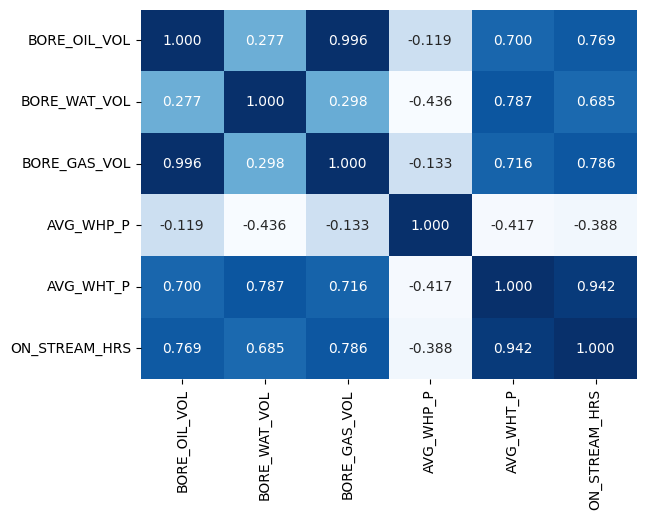

In [48]:
sns.heatmap(target.corr(),annot=True, cbar=False, cmap='Blues', fmt='.3f')

#### Preparação da base de dados para criação do modelo

In [49]:
# Scaling the entire dataset

dataset = target
values = dataset.values

values = values.astype('float32')

# Fazendo uma normalização nos dados para ficarem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [50]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 4, 1) # 7,10 ficou horrivel # Ficou melhorzinho 4>5>1>3>2
print(reframed.shape)

(740, 30)


In [51]:
display(reframed.head())

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.247753,0.125628,0.0,0.0,0.0,0.0,0.165079,0.104342,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.165079,0.104342,0.0,0.0,0.0,0.0,0.205871,0.112960,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.247753,...,0.0,0.205871,0.112960,0.0,0.0,0.0,0.0,0.157161,0.097474,0.0
7,0.0,0.0,0.0,0.247753,0.125628,0.0,0.0,0.0,0.0,0.165079,...,0.0,0.157161,0.097474,0.0,0.0,0.0,0.0,0.104179,0.101873,0.0
8,0.0,0.0,0.0,0.165079,0.104342,0.0,0.0,0.0,0.0,0.205871,...,0.0,0.104179,0.101873,0.0,0.0,0.0,0.0,0.030840,0.105744,0.0


#### Visualização das novas colunas criadas no processo

In [52]:
reframed.columns

Index(['var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)',
       'var6(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)',
       'var5(t-3)', 'var6(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)',
       'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var1(t-1)', 'var2(t-1)',
       'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var1(t)',
       'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)'],
      dtype='object')

In [53]:
target.columns

Index(['BORE_OIL_VOL', 'BORE_WAT_VOL', 'BORE_GAS_VOL', 'AVG_WHP_P',
       'AVG_WHT_P', 'ON_STREAM_HRS'],
      dtype='object')

#### Como o objetivo desse notebook é a previsão apenas de óleo, vamos remover as outras colunas no instante t

In [54]:
# droping columns we don't want to predict
columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)']
reframed.drop(columns_to_drop, axis=1, inplace=True)
display(reframed.head(2))

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),...,var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var6(t)
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.247753,0.125628,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125628,0.0,0.0,0.0,0.0,0.165079,0.104342,0.0,0.0,0.0


In [55]:
# Column name to move to the last position
column_name = 'var1(t)'

# Ensure the column exists in the DataFrame
if column_name in reframed:
    # Create a list of column names excluding the one you want to move
    columns = [col for col in reframed.columns if col != column_name]
    
    # Reorder the DataFrame with the selected column at the end
    reframed = reframed[columns + [column_name]]
else:
    print(f"'{column_name}' not found in the DataFrame.")

In [56]:
reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),...,var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t),var1(t)
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.247753,0.125628,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.125628,0.0,0.0,0.0,0.0,0.165079,0.104342,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.247753,...,0.104342,0.0,0.0,0.0,0.0,0.205871,0.112960,0.0,0.0,0.0
7,0.0,0.0,0.0,0.247753,0.125628,0.0,0.0,0.0,0.0,0.165079,...,0.112960,0.0,0.0,0.0,0.0,0.157161,0.097474,0.0,0.0,0.0
8,0.0,0.0,0.0,0.165079,0.104342,0.0,0.0,0.0,0.0,0.205871,...,0.097474,0.0,0.0,0.0,0.0,0.104179,0.101873,0.0,0.0,0.0


#### Vamos definir o percentual de dados que vai ser utilizada no treino e no teste

In [57]:
train_ratio = 0.8

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

##### Separação dos dados de treino e teste

In [58]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = split_index

train = values[:split_index, :]
test = values[split_index:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(595, 1, 25) (595,) (145, 1, 25) (145,)


#### Definição da quantidade de neuronios que vão ser utilizados

In [59]:
n_neurons = 50 
n_neurons

50

#### Criação do modelo

In [60]:
model_LSTM = Sequential()
model_LSTM.reset_states()
model_LSTM.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model_LSTM.add(LSTM(n_neurons, return_sequences=True))
model_LSTM.add(LSTM(n_neurons, return_sequences=False))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             15200     
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 55,651
Trainable params: 55,651
Non-trainable params: 0
_________________________________________________________________


#### Definindo a quantiade de epocas e informando que todos os dados serão utilizados no processo de treinamento

In [61]:
epochs = 300 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [62]:
train_X.shape

(595, 1, 25)

#### Treinamento do modelo

In [63]:
# Train the model
history_LSTM = model_LSTM.fit(train_X, train_y, batch_size=batch_size, epochs=epochs)
train_loss_history_LSTM = history_LSTM.history['loss']

Epoch 1/300
595/595 [==============================] - 3s 3ms/step - loss: 0.0107 - mean_absolute_error: 0.0650
Epoch 2/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0412
Epoch 3/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0400
Epoch 4/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0373
Epoch 5/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0367
Epoch 6/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0389
Epoch 7/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0355
Epoch 8/300
595/595 [==============================] - 2s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0356
Epoch 9/300
595/595 [==============================] - 3s 5ms/step - loss: 0.0031 - mean_absolute_error:

In [64]:
testPredict = model_LSTM.predict(test_X)
print(testPredict.shape)
testPredict_scaled = testPredict.ravel()

print(testPredict_scaled.shape)

5/5 [==============================] - 1s 4ms/step
(145, 1)
(145,)


In [65]:
y_test_true_scaled = test_y

#### Recuperando a escala dos dados

In [66]:
poll = np.array(target["BORE_OIL_VOL"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = train_y * stdop + meanop
testPredict = testPredict_scaled * stdop + meanop

In [67]:
trainPredict = model_LSTM.predict(train_X)
print(trainPredict.shape)
trainPredict_scaled = trainPredict.ravel()

print(trainPredict_scaled.shape)

19/19 [==============================] - 0s 4ms/step
(595, 1)
(595,)


In [68]:
# Recuperando os dados de treino

poll = np.array(target["BORE_OIL_VOL"])

meanop = poll.mean()
stdop = poll.std()

y_train_true = y_test_true_scaled * stdop + meanop
trainPredict = trainPredict_scaled * stdop + meanop

#### Plotando a resposta final do processo

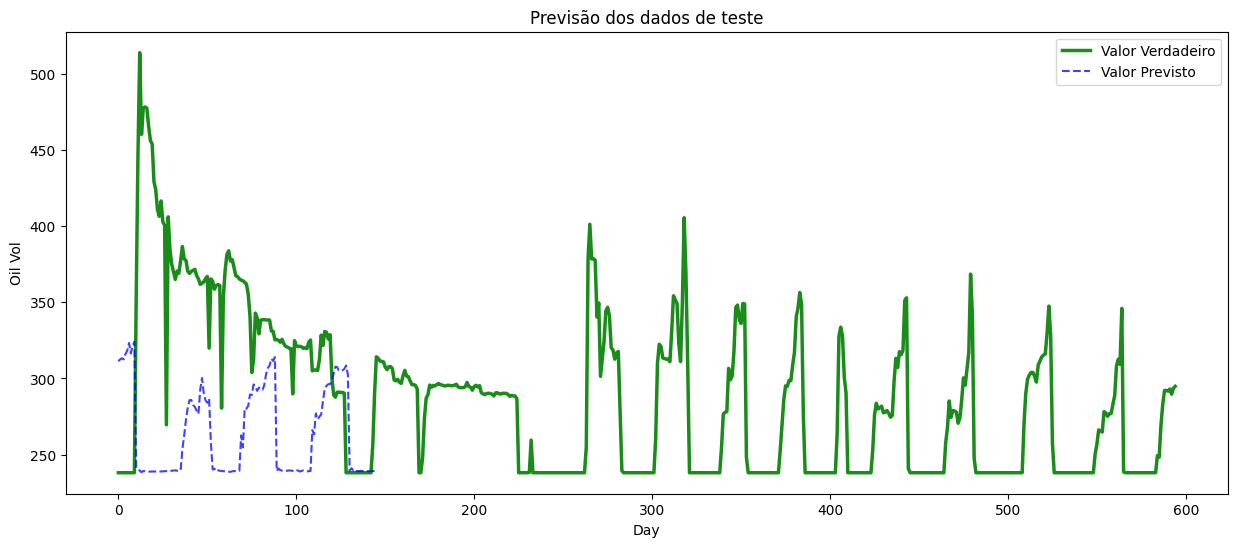

In [69]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
# plt.xlim([1000,1250])
plt.ylabel("Oil Vol")
plt.xlabel("Day")
plt.plot(y_test_true, "g", alpha = 0.90, linewidth = 2.5,label='Valor Verdadeiro')
plt.plot(testPredict, "--b", alpha = 0.75,label='Valor Previsto')
plt.legend()
plt.title("Previsão dos dados de teste")
plt.show()

In [70]:
rmse = np.sqrt(mean_squared_error(y_test_true_scaled, testPredict_scaled))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.0384295


In [71]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

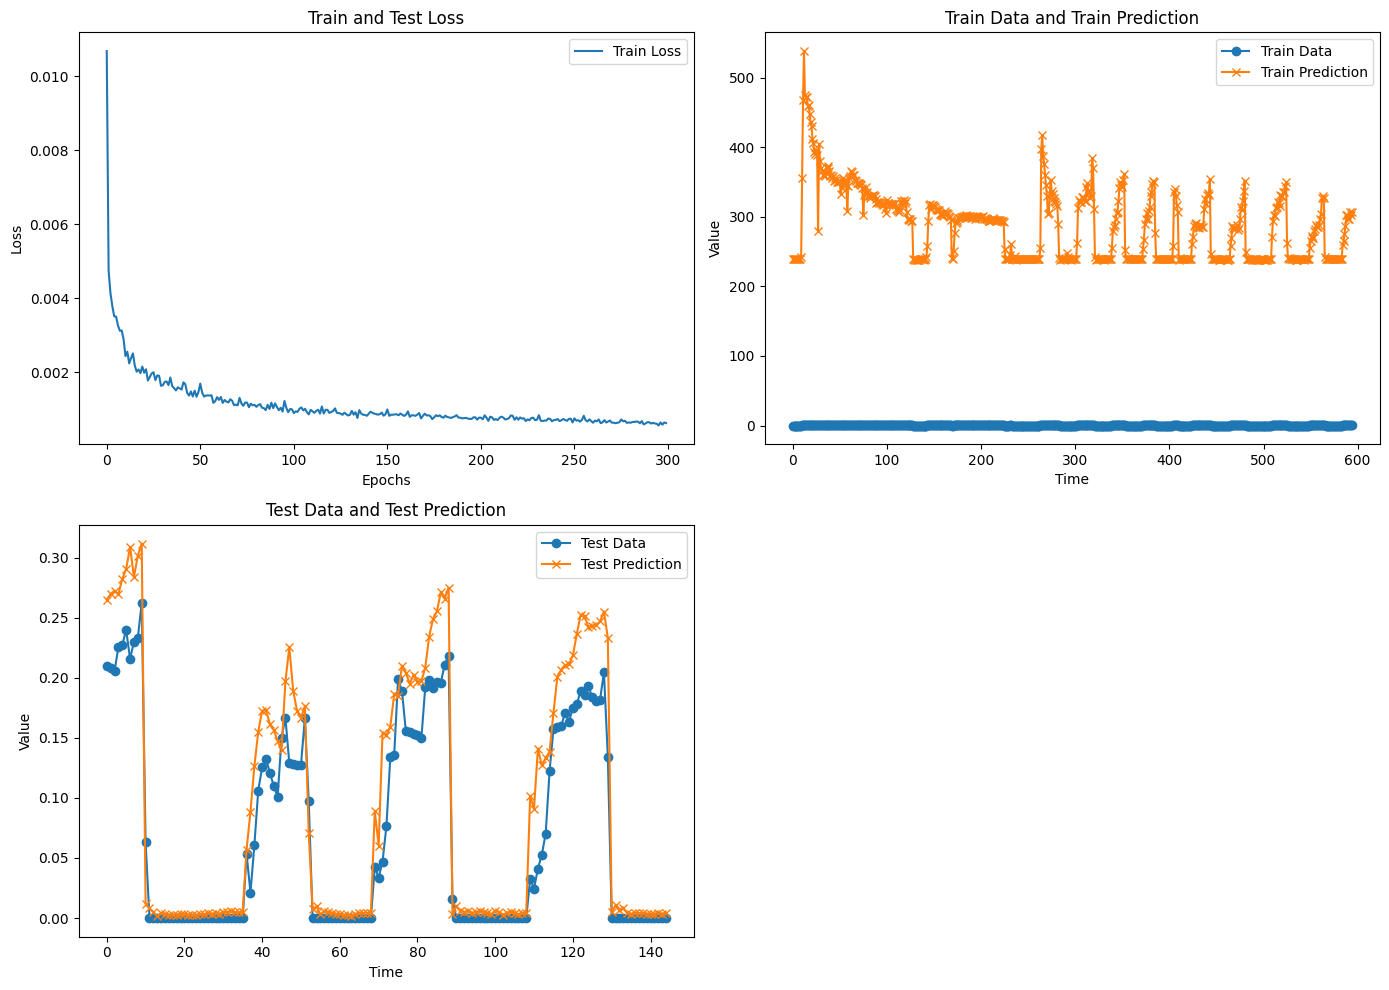

In [72]:
# Plot the graphs
plot_result_graphs(train_loss_history_LSTM, train_y, trainPredict, y_test_true_scaled, testPredict_scaled)